## Predicting Yelp Review Popularity

Using the academic data set provided by Yelp, we attempt to create a machine learning model that help predict the popularity of Yelp reviews such that new reviews can be given a score to rank against existing reviews.

This notebook os structured as followed:
* [Download Yelp Data](#data-download)
* [Data Exploration and Pre-processing](#pre-processing)
    * [Business data](#bus-data)
    * [Review data](#rev-data)
        * [Response Variable Transformation](#rev-data-response)
        * [LDA Topic Modelling](#rev-data-LDA)
        * [Linguistic Features](#rev-data_lin)
    * [User Data](#user-data)
    * [Complete Merge](#full-df)
        * [Feature Engineering](#full-df-engineering)
* [Machine Learning Pipeline](#main-ml)

Code used for cluster creation:

In [85]:
'''BUCKET="mybucket-rm"
gcloud beta dataproc clusters create cluster1 --bucket ${BUCKET} --region europe-west2 --zone europe-west2-c --master-machine-type n2-standard-2 --master-boot-disk-size 500 --num-workers 2 --worker-machine-type n2-standard-2 --worker-boot-disk-size 500 --image-version=1.5-debian10 --optional-components=ANACONDA,JUPYTER --enable-component-gateway --initialization-actions gs://${BUCKET}/my_actions.sh --metadata 'PIP_PACKAGES=sklearn nltk pandas numpy' --project finalbigdataproject-422420
'''

'BUCKET="mybucket-rm"\ngcloud beta dataproc clusters create cluster1 --bucket ${BUCKET} --region europe-west2 --zone europe-west2-c --master-machine-type n2-standard-2 --master-boot-disk-size 500 --num-workers 2 --worker-machine-type n2-standard-2 --worker-boot-disk-size 500 --image-version=1.5-debian10 --optional-components=ANACONDA,JUPYTER --enable-component-gateway --initialization-actions gs://${BUCKET}/my_actions.sh --metadata \'PIP_PACKAGES=sklearn nltk pandas numpy\' --project finalbigdataproject-422420\n'

The above code creates a Dataproc cluster named "cluster1". The cluster is created in the "europe-west2" region and "europe-west2-c" zone, with a master node of type "n2-standard-2" and a boot disk size of 500 GB. It has two worker nodes, also of type "n2-standard-2" with 500 GB boot disks.

In [1]:
import json
import os
import matplotlib.pyplot as plt
import re
import numpy as np
import math

# pypark dataporcessing
from pyspark.sql.functions import col, to_timestamp,when, udf, expr,year
from pyspark.sql.types import StructType, StructField, StringType, IntegerType,ShortType, TimestampType, FloatType,ArrayType,BooleanType,DoubleType
import pyspark.sql.functions as sql_f

# global parameters
cluster_name = "cluster1"
cluster_port = 8020

In [2]:
pip install profanity-check

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 82.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install profanity-check gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 8.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 9.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


<a id = "set-up"></a>
### Setting Up for NLP

In [87]:
# natural language processing packages
# gensim, kaggle, profanity-check, textblob installed at cluster initialisation
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
from nltk.tokenize import TweetTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
from profanity_check import predict
import string

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import LDA

<a id = "data-download"></a>
## Download Yelp Data
Although Yelp provides a [download link](https://www.yelp.com/dataset/download) to their dataset, the link is only valid for 30 seconds afer it is generated. Alternatively, the Yelp dataset can be accessed through the [Kaggal API](https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset). To download the dataset, an [API token](https://www.kaggle.com/docs/api) need to be created and passed in to the following script as:
* username
* api_token


In [5]:
!mkdir ~/.kaggle
#!touch ~/.kaggle/kaggle.json

In [6]:
pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 19.9 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.12-py3-none-any.whl size=102974 sha256=54f09371f284dbd10f8958954ada38e00317e0340d883513cf189be7929f540e
  Stored in directory: /root/.cache/pip/wheels/6d/00/bd/a7b836e7e94f733cef5a0f274b7e991c045a6ab60cfd285fdd
Successfully built kaggle
  Attempting uninstall: certifi
    Found existing installation: certifi 2019.9.11
    Uninstalling certifi-2019.9.11:
      Successfully uninstalled certifi-2019.9.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kubernetes 27.2.0 requires pyyaml>=5.4.1, but you have pyyaml 5.1.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [7]:
# define the kaggle api key
username = ""
key = ""
api_token = {"username":username,"key":key}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# download the data set
!kaggle datasets download -d yelp-dataset/yelp-dataset

Dataset URL: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset
License(s): other
100%|█████████████████████████████████████▉| 4.07G/4.07G [01:42<00:00, 44.0MB/s]
100%|██████████████████████████████████████| 4.07G/4.07G [01:42<00:00, 42.6MB/s]


In [9]:
# unzip the files and pass into yelf_dataset folder
!unzip yelp-dataset.zip -d yelp_dataset

Archive:  yelp-dataset.zip
  inflating: yelp_dataset/Dataset_User_Agreement.pdf  
  inflating: yelp_dataset/yelp_academic_dataset_business.json  
  inflating: yelp_dataset/yelp_academic_dataset_checkin.json  
  inflating: yelp_dataset/yelp_academic_dataset_review.json  
  inflating: yelp_dataset/yelp_academic_dataset_tip.json  
  inflating: yelp_dataset/yelp_academic_dataset_user.json  


In [10]:
# move the file into the hadoop fs
!hadoop fs -put ./yelp_dataset/*.json /

<a id = "pre-processing"></a>
## Data Exploration and Pre-Processing
While the main feature engineering will be done in the next section, we will also process the data to add or remove the dimension using features available in the dataframe.

With the addition of the business dataset and the user dataset, we can increase the data space of the review dataset by creating summary statistics on the business dataset and the user dataset and merge it to the reviews dataset on "business_id" and "user_id" respectively.

Here are some pre-processing we may produce individually on the data set before merging them:<br>
* Natural Lanauge Process
    * Latent Dirichlet Allocation Topic Modelling (k = 3)
    * Polarity Score
    * Subjectivity
    * Review length
    
* Quantitative Feature Engineeering
    * Review star rating
    * Reviewer number of friends
    * Reviewer number of fans
    * Reviewer compliment received (eg. cool, funny, useful)
    * Boolean value for chain stores
    
Some other data that may be relevant can be computed when the data are merged: <br> 
* Reviewer experience (df_rev.date - df_cus.yelping_since)
* Reviewer elite status at review YEAR(date)
    
While we are able to adjust for the user elite status and the experience based on the timestamp of the review, we cannot recursively compute the number of cumulative compliments the reviewer received at the time of leaving the review. This may have a short comining in terms of the aggregate compliment as a predictor. 

In [3]:
# define the file name
files = [ "yelp_academic_dataset_business.json",
            "yelp_academic_dataset_checkin.json",
            "yelp_academic_dataset_review.json", 
            "yelp_academic_dataset_tip.json",
            "yelp_academic_dataset_user.json"]
# custom define function for exploring the data
def groupby_size(col_name: str, df):
    """
    return a pyspark rdd object with (key,value) pair
    to as a frequency table of the observation of the keys
    """
    df= (df.rdd
        .map(lambda row: row[col_name]) # subset the column
        .map(lambda x: (x,1)) # add counter
        .reduceByKey(lambda obs_n , obs_m: obs_n + obs_m)
        .collect())
    return df

<a id = "bus-data"></a>
### Business dataset

In [4]:
path = f"hdfs://{cluster_name}-m:{cluster_port}/{files[0]}"
df_bus = spark.read.json(path)
df_bus.limit(2).toPandas()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,"1616 Chapala St, Ste 2","(None, None, None, None, None, None, None, Non...",Pns2l4eNsfO8kk83dixA6A,"Doctors, Traditional Chinese Medicine, Naturop...",Santa Barbara,None,0,34.426679,-119.711197,"Abby Rappoport, LAC, CMQ",93101,7,5.0,CA
1,87 Grasso Plaza Shopping Center,"(None, None, None, None, None, None, None, Non...",mpf3x-BjTdTEA3yCZrAYPw,"Shipping Centers, Local Services, Notaries, Ma...",Affton,"(8:0-18:30, 0:0-0:0, 8:0-14:0, None, 8:0-18:30...",1,38.551126,-90.335695,The UPS Store,63123,15,3.0,MO


In [5]:
print(f"The number of business in the table: {df_bus.count()}")

The number of business in the table: 150346


#### Pre-Processing: Business data
With the business dataset, we can add a new column to determine whether a business is a chain or not.

In [6]:
# return the frequency table of shop
shop_count = groupby_size("name", df_bus)
print(f"Number of unique business {len(shop_count)}")

Number of unique business 114117


In [7]:
# define the schema and print the result
schema_count= StructType([StructField("_1",StringType(),False),StructField("_2",ShortType(),False)])
shop_count_df = spark.createDataFrame(shop_count, schema = schema_count)\
                    .withColumnRenamed("_1","shop_name")\
                    .withColumnRenamed("_2","count")
# inspect the top rows
shop_count_df.orderBy(sql_f.desc("count")).show(5)

+----------+-----+
| shop_name|count|
+----------+-----+
| Starbucks|  724|
|McDonald's|  703|
|   Dunkin'|  510|
|    Subway|  459|
| Taco Bell|  365|
+----------+-----+
only showing top 5 rows



In [8]:
# inspect the aggregation
shop_count_df.createOrReplaceTempView("shop_count")
sql_query = """
    SELECT 
        CASE 
            WHEN count > 1 THEN 'Chain'
            ELSE 'Non-chain'
        END AS class,
        COUNT(*) AS count
    FROM shop_count
    GROUP BY 
        CASE 
            WHEN count > 1 THEN 'Chain'
            ELSE 'Non-chain'
        END
    """
spark.sql(sql_query).show()

+---------+------+
|    class| count|
+---------+------+
|Non-chain|106138|
|    Chain|  7979|
+---------+------+



By inspection of the top 300 rows, we observed that chain stores such as Subway has a little of 20 stores in this data. While there is not a convenient way to determine the cut off point for identifying small local chains to larger chains, we can see that there are not that many business that is classified as a chain with the sql command above. Hence, we will simply assume that stores with more than one location is a chain.

In [9]:
# chain store list
chain_list = spark.sql("SELECT shop_name FROM shop_count WHERE count > 1").collect()
print(f"{len(chain_list)} chains identified")

7979 chains identified


In [10]:
# Define a function to check if a shop is in the chain_list
def check_in_list(val, string_list = chain_list):
    return val in string_list
# Register the function as a UDF
check_in_list_udf = udf(check_in_list, StringType())

In [11]:
# add chain column to the business dataframe
df_bus = df_bus.withColumn("chain", 
                           check_in_list_udf(df_bus["name"]))\
            .cache()

In [12]:
# add chain column to the business dataframe
df_bus = df_bus.withColumn("chain", 
                           check_in_list_udf(df_bus["name"]))\
            .cache()
# inspect the dataframe
df_bus.limit(2).toPandas()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,chain
0,"1616 Chapala St, Ste 2","(None, None, None, None, None, None, None, Non...",Pns2l4eNsfO8kk83dixA6A,"Doctors, Traditional Chinese Medicine, Naturop...",Santa Barbara,None,0,34.426679,-119.711197,"Abby Rappoport, LAC, CMQ",93101,7,5.0,CA,false
1,87 Grasso Plaza Shopping Center,"(None, None, None, None, None, None, None, Non...",mpf3x-BjTdTEA3yCZrAYPw,"Shipping Centers, Local Services, Notaries, Ma...",Affton,"(8:0-18:30, 0:0-0:0, 8:0-14:0, None, 8:0-18:30...",1,38.551126,-90.335695,The UPS Store,63123,15,3.0,MO,false


In [13]:
# remove the columns that will not be used for our purpose
df_bus_subset = df_bus.select(["business_id","state","chain"]).cache()
# inspect the frame
df_bus_subset.limit(2).toPandas()

,business_id,state,chain
0,Pns2l4eNsfO8kk83dixA6A,CA,false
1,mpf3x-BjTdTEA3yCZrAYPw,MO,false


<a if = "rev-data"></a>
### Review dataset
Although there are time zone difference, we are not concern with the exact time but only the date. Hence, we keep the `date` column to be timezone naive.

Note that when we load the `.json` file, there exist a [bug](https://community.databricks.com/t5/data-engineering/spark-issue-handling-data-from-json-when-the-schema-datatype/td-p/13495) in the spark pipeline that cannot take the schema when rading the data frame. Hence, we will load the data first and then type cast the data.

In [14]:
# load the data
path = f"hdfs://{cluster_name}-m:{cluster_port}/{files[2]}"
df_rev = spark.read.format("json").load(path)
df_rev.limit(2).toPandas()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,XQfwVwDr-v0ZS3_CbbE5Xw,0,2018-07-07 22:09:11,0,KU_O5udG6zpxOg-VcAEodg,3.0,"If you decide to eat here, just be aware it is...",0,mh_-eMZ6K5RLWhZyISBhwA
1,7ATYjTIgM3jUlt4UM3IypQ,1,2012-01-03 15:28:18,0,BiTunyQ73aT9WBnpR9DZGw,5.0,I've taken a lot of spin classes over the year...,1,OyoGAe7OKpv6SyGZT5g77Q


In [15]:
print(f"The number of reviews in the dataset: {df_rev.count()}")

The number of reviews in the dataset: 6990280


In [16]:
df_rev.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [17]:
# apply type casting on the date type
df_rev = df_rev.withColumn("date", col("date").cast(TimestampType())).cache()
df_rev.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



<a id = "rev-data-response"></a>
#### Data Exploration - Response Variable
We want to explore the review data to see what the "cool", "funny" and "useful" columns refer to. Namely, we can inspect the range of the values the data can take.

In [18]:
def plot_scatter_dist(rdd_data, x_axis):
    """
    convert and rdd of (key, frequency) pair
    to log_normal scale scatter plot
    """
    # extract the number
    (x_values, y_values) = zip(*col_summ)
    # create the plot
    fig, ax = plt.subplots(figsize = (6,6))
    ax.scatter(x = x_values, y = y_values, alpha = 0.5)
    # ax.set_xscale('log')
    ax.set_yscale('log')
    # add annotatiom
    ax.set_ylabel("Frequency")
    ax.set_xlabel(x_axis)

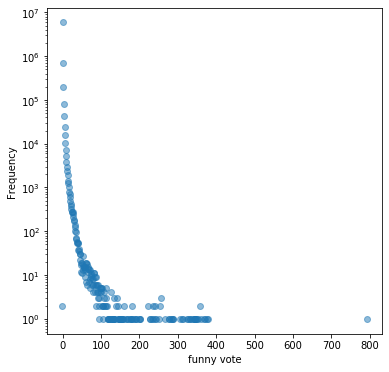

In [19]:
# get the summary for funny vote
col_summ = groupby_size("funny", df_rev)
plot_scatter_dist(col_summ, "funny vote")

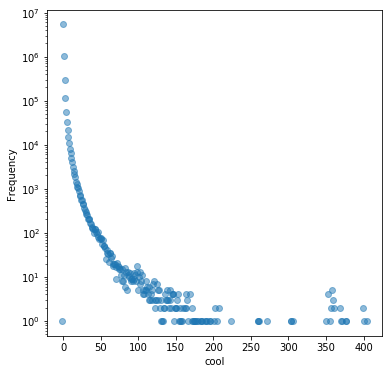

In [18]:
# get the summary for 
col_summ = groupby_size("cool", df_rev)
plot_scatter_dist(col_summ, "cool")

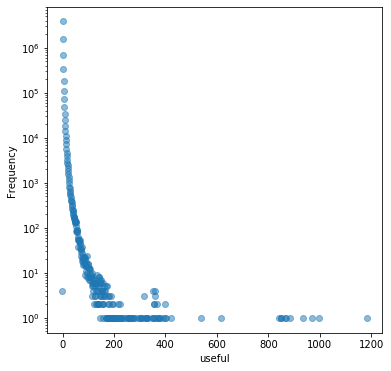

In [19]:
# get the summary for 
col_summ = groupby_size("useful", df_rev)
plot_scatter_dist(col_summ, "useful")

##### Transforming the Scores
We want to combine the useful vote, funny vote, and cool vote into a single "popularity" score. We want to specify the popularity score such that it has a range of [0,1] as a monotonous increasingly function of votes with marginal return. In addition, it should be a weight sum of all components. Recognising that the domain is an positive interger (including zero), one way to specify the function is:

$$\frac{1}{3}\sum^3_{i=1}\frac{x_i}{10+x_i}$$

where $i$ denotes the vote type and $x_i$ denotes the vote count for each category. We define the function this way to avoid a transformation that yields a popularity score with a skew towards $1$.

In the chunks below, we execute the reciprocal transformation:

In [19]:
df_rev.filter(col("useful") < 0).count()

4

In [20]:
df_rev.filter(col("cool") < 0).count()

1

In [21]:
df_rev.filter(col("funny") < 0).count()

2

We do see these columns contain negative values. We filter out all the rows for which the columns useful, cool and funny have negative value.

In [22]:
df_rev = df_rev.filter((col("useful") >= 0) & (col("cool") >= 0) & (col("funny") >= 0))

In [23]:
# define the transformation function
def reciprocal(x, scale = 10):
    return x / (scale + x)

# register the function as pyspark udf function
reciprocal_udf = udf(reciprocal, DoubleType())

#### Popularity Score just with reciprocal

In [24]:
# type casting the vote count columns
df_rev = df_rev.withColumn("cool", col("cool").cast("double"))\
                .withColumn("funny", col("funny").cast("double"))\
                .withColumn("useful", col("useful").cast("double"))\
                .cache()

In [25]:
# apply the sigmoid transformation to the vote count
df_rev = df_rev.withColumn("target_cool", reciprocal_udf("cool")/3)\
                .withColumn("target_funny", reciprocal_udf("funny")/3)\
                .withColumn("target_useful", reciprocal_udf("useful")/3)\

In [26]:
df_rev = df_rev.withColumn("PopularityScore", (col("target_cool") + col("target_funny") + col("target_useful")))

In [27]:
df_rev.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- funny: double (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: double (nullable = true)
 |-- user_id: string (nullable = true)
 |-- target_cool: double (nullable = true)
 |-- target_funny: double (nullable = true)
 |-- target_useful: double (nullable = true)
 |-- PopularityScore: double (nullable = true)



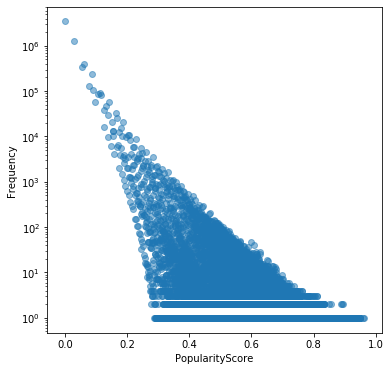

In [40]:
col_summ = groupby_size("PopularityScore", df_rev)
# plot histogram
plot_scatter_dist(col_summ, "PopularityScore")

#### Pre-Processing: Review data
With the review data set, we want to do the following:
* Fit LDA topics
* Get polarity score
* Get subjectivity score
* Get length of review

Since the data set is very large, containing about 7M reviews data, it takes significant time to conduct natural language 
processing on the dataset.  Hence, we will only subset 1% of the data for our initial analysis.

In [28]:
# subset 1% of the review data
df_rev_01 = df_rev.sample(withReplacement = False, fraction = 0.01,seed = 42).cache()

<a id = "rev-data-LDA"></a> 
##### LDA Topic Modelling
Before fitting with LDA into three clusters, we will process the review text.

In [29]:
# Preprocess the review data and get tokens
stop_words = set(stopwords.words('english'))
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
lmtzr = WordNetLemmatizer() 
def get_tokens(line):
    t = line.replace('\xa0', ' ')
    tokens = word_tokenize(t)
    tokens = [w.lower() for w in tokens]
    stripped = [w.translate(table) for w in tokens]
    # transform word to root and remove punctuations
    words = [word for word in stripped if word.isalpha()]
    words = [w for w in words if not w in stop_words]
    words = [lmtzr.lemmatize(w) for w in words]
    return (words)

# apply on the review data set
df_rev_pro = df_rev_01.rdd.map(lambda line: (line["review_id"], get_tokens(line["text"])))
# return as dataframe
df_rev_pro = spark.createDataFrame(df_rev_pro, ["review_id","content"]).cache()

In [32]:
# fit and transform countvectorizer to the review content 
maxDF = 1000 # about 10% of the subset dataframe (currently 60k)
cv = CountVectorizer(inputCol="content", outputCol="features", minDF=10, maxDF=6000)
cv_model = cv.fit(df_rev_pro)
df_rev_pro = cv_model.transform(df_rev_pro)
df_rev_pro.cache()
# inspect the result
df_rev_pro.limit(5).toPandas()

,review_id,content,features
0,6AxgBCNX_PNTOxmbRSwcKQ,"[loved, tour, grabbed, groupon, price, great, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,pl5AjpEcFxFTltkBvHjsRA,"[location, twice, never, go, back, first, time...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,zcj7iTXdSz0GCBOReMTeiQ,"[menu, satisfies, everyone, craving, clean, tr...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,qSCCNv6JsHpQL8_uJoL9zQ,"[place, absolutely, awesome, cent, oyster, doz...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,NYxYahcPBsyVSE88IHNivA,"[honestly, know, place, existed, friend, sugge...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


In [ ]:
# fit a LDA
lda = LDA(k=3, maxIter=4)
# transform the review data
lda_model = lda.fit(df_rev_pro)
# print the result
topics = lda_model.describeTopics(6)
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)
topic_i = topics.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_i:
    print(np.array(cv_model.vocabulary)[i])

The topics described by their top-weighted terms:
+-----+---------------------------+---------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                |termWeights                                                                                                                            |
+-----+---------------------------+---------------------------------------------------------------------------------------------------------------------------------------+
|0    |[4, 13, 1, 3, 17, 20]      |[0.004693525856831136, 0.0042324585752757556, 0.00413897731706681, 0.0038925200662154567, 0.0036146108052348617, 0.0032568799554650576]|
|1    |[5, 0, 15, 11, 2, 12]      |[0.004670078225491099, 0.004229474436087164, 0.0037036319752743246, 0.003467313605353107, 0.00338300040232275, 0.003379292744046658]   |
|2    |[22, 66, 14, 133, 234, 131]|[0.004966236586648221, 0.004509002607438776, 0.00388730

In [34]:
# fitting the LDA model to the data taking only the result
df_rev_pro_lda = lda_model.transform(df_rev_pro)\
                    .drop(*["content","features"])\
                    .cache()

In [35]:
# split the topic array to 3 separate columns
schema = ["review_id", "topic0","topic1","topic2"]
df_rev_pro_lda = (df_rev_pro_lda.rdd
                     .map(lambda row: (row["review_id"], row["topicDistribution"]))
                     .map(lambda row: (row[0], float(row[1][0]),float(row[1][1]),float(row[1][2])))
                        ).toDF(schema = schema)

In [36]:
# inspect the result
df_rev_pro_lda.limit(2).toPandas()

,review_id,topic0,topic1,topic2
0,6AxgBCNX_PNTOxmbRSwcKQ,0.867488,0.126457,0.006055
1,pl5AjpEcFxFTltkBvHjsRA,0.323880,0.668322,0.007798


<a id = "#rev-data_lin"></a>
##### Linguistic Features

In addition to the LDA topic modelling, we are also intersted in other linguistic features.

In [37]:
# define the processing pipeline
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    
    senti = sia()
    tt = TweetTokenizer()

    pos_family = {
        'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
        'pron': ['PRP', 'PRP$', 'WP', 'WP$'],
        'verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
        'adj': ['JJ', 'JJR', 'JJS'],
        'adv': ['RB', 'RBR', 'RBS', 'WRB']
    }

    def polarity(x):
        ss = TextBlob(str(x))
        return round(ss.sentiment.polarity, 4)

    def subjectivity(x):
        ss = TextBlob(str(x))
        return round(ss.sentiment.subjectivity, 4)

    def getfeatures(review_id,review):
        pol = polarity(review)
        subj = subjectivity(review)

        tokens = tt.tokenize(review)
        review_length = len(tokens)

        char_count = len(review)
        worddensity = char_count / (review_length + 1)
        punctuation_count = len("".join(_ for _ in review if _ in string.punctuation))
        upper_case_word_count = len([w for w in review.split() if w.isupper()])

        return {
            "review_id" : review_id,
            'polarity': pol,
            'subjectivity': subj,
            'review_length': review_length,
            'char_count': char_count,
            'word_density': worddensity,
            'punctuation_count': punctuation_count,
            'upper_case_word_count': upper_case_word_count}

In [38]:
# testing the pipeline
df_rev_pro_lin = df_rev_01.rdd.map(lambda row: getfeatures(row["review_id"],row["text"])).toDF()
# inspect the result
df_rev_pro_lin.limit(2).toPandas()

/usr/lib/spark/python/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


,char_count,polarity,punctuation_count,review_id,review_length,subjectivity,upper_case_word_count,word_density
0,804,0.2897,22,6AxgBCNX_PNTOxmbRSwcKQ,168,0.4394,3,4.757396
1,675,-0.0506,15,pl5AjpEcFxFTltkBvHjsRA,139,0.4120,1,4.821429


##### Merging the dataframes
With the above code, we have created three data tables, all from the review data. In this section, we will merge them together. Namely, we will merge:
*  Response Variable
* `df_rev_pro_lda` for the LDA topic modelling
* `df_rev_pro_lin` for the Linguistic Features

In [39]:
df_rev_pro_lda.columns

['review_id', 'topic0', 'topic1', 'topic2']

In [40]:
df_rev_pro_lin.columns

['char_count',
 'polarity',
 'punctuation_count',
 'review_id',
 'review_length',
 'subjectivity',
 'upper_case_word_count',
 'word_density']

In [41]:
# lda with lin
df_rev_subset = df_rev_pro_lin.join(df_rev_pro_lda, 
                            df_rev_pro_lda.review_id == df_rev_pro_lin.review_id,
                            "left")\
                            .drop(df_rev_pro_lin["review_id"])

In [42]:
df_rev_subset = df_rev_subset.join(df_rev, df_rev.review_id == df_rev_subset.review_id, "left").drop(df_rev_subset.review_id)

In [43]:
df_rev_subset.columns

['char_count',
 'polarity',
 'punctuation_count',
 'review_length',
 'subjectivity',
 'upper_case_word_count',
 'word_density',
 'topic0',
 'topic1',
 'topic2',
 'business_id',
 'cool',
 'date',
 'funny',
 'review_id',
 'stars',
 'text',
 'useful',
 'user_id',
 'target_cool',
 'target_funny',
 'target_useful',
 'PopularityScore']

In [44]:
df_rev_subset.printSchema()

root
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- topic0: double (nullable = true)
 |-- topic1: double (nullable = true)
 |-- topic2: double (nullable = true)
 |-- business_id: string (nullable = true)
 |-- cool: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- funny: double (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: double (nullable = true)
 |-- user_id: string (nullable = true)
 |-- target_cool: double (nullable = true)
 |-- target_funny: double (nullable = true)
 |-- target_useful: double (nullable = true)
 |-- PopularityScore: double (nullable = true)



##### Subset the Review Data

In [45]:
# define the columns needed
sel_cols = ['business_id', 'user_id', 'char_count','polarity','punctuation_count', 'review_length', 'subjectivity', 'upper_case_word_count', 
            'word_density', 'topic0', 'topic1', 'topic2', 'date', 'stars', 'text', 'PopularityScore']
df_rev_subset = df_rev_subset.select(sel_cols).cache()

In [ ]:
# export to create static view of the dataframe
file_name = "yelp_academic_dataset_review_processed_new.json"
path = f"hdfs://{cluster_name}-m:{cluster_port}/{file_name}"
df_rev_subset.write.json(path)

In [46]:
df_rev_subset.columns

['business_id',
 'user_id',
 'char_count',
 'polarity',
 'punctuation_count',
 'review_length',
 'subjectivity',
 'upper_case_word_count',
 'word_density',
 'topic0',
 'topic1',
 'topic2',
 'date',
 'stars',
 'text',
 'PopularityScore']

<a if = "user-data"></a>
### User dataset

In [47]:
# load the data
path = f"hdfs://{cluster_name}-m:{cluster_port}/{files[4]}"
df_cus = spark.read.json(path)
df_cus.limit(5).toPandas()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,3.91,467,56,467,250,18,65,232,180,844,...,5994,2007,267,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",1259,Walker,585,7217,qVc8ODYU5SZjKXVBgXdI7w,2007-01-25 16:47:26
1,3.74,3131,157,3131,1145,251,264,1847,1946,7054,...,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",3138,"ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",13066,Daniel,4333,43091,j14WgRoU_-2ZE1aw1dXrJg,2009-01-25 04:35:42
2,3.32,119,17,119,89,3,13,66,18,96,...,1003,"2009,2010,2011,2012,2013",52,"LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",1010,Steph,665,2086,2WnXYQFK0hXEoTxPtV2zvg,2008-07-25 10:41:00
3,4.27,26,6,26,24,2,4,12,9,16,...,299,"2009,2010,2011",28,"enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",330,Gwen,224,512,SZDeASXq7o05mMNLshsdIA,2005-11-29 04:38:33
4,3.54,0,0,0,1,0,1,1,0,1,...,7,,1,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",15,Karen,79,29,hA5lMy-EnncsH4JoR-hFGQ,2007-01-05 19:40:59


In [48]:
print(f"The number of users in the table: {df_cus.count()}")

The number of users in the table: 1987897


In [49]:
# apply type casting on the date type
df_cus = df_cus.withColumn("yelping_since", col("yelping_since").cast(TimestampType())).cache()
df_cus.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: timestamp (nullable = true)



#### Pre-Processing: Reviewer (customer)
In the following section, we will pre-process the customer data with the procedures:
* Aggregate the compliment received
* Aggregate compliment sent
* Parse the elite column as a list of int
* Get aggerate of number friends

In [50]:
# first check for any na value
column_names = df_cus.columns
# Calculate the number of NA values in each column
na_counts = [sql_f.sum(col(column).isNull().cast("integer")).alias(column) for column in column_names]
# Perform the aggregation to get the total NA counts per column
na_counts_df = df_cus.agg(*na_counts)
# Show the DataFrame with NA counts
na_counts_df.show()

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+----+------------+------+-------+-------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|friends|funny|name|review_count|useful|user_id|yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+----+------------+------+-------+-------------+
|            0|              0|              0|               0|             0|              0|              0|              0|                0|               0|       

In [51]:
## get the compliment aggregate
# get the compliment column names
compliment_cols = [column for column in df_cus.columns if column.find("compliment") >=0]
# remove cool, funny, and useful
for column in ["compliment_cool","compliment_funny"]:
    compliment_cols.remove(column)
# define the sql expression to sum the column and return new column
sum_expr = sum(col(col_name) for col_name in compliment_cols)
df_cus = df_cus.withColumn("compliment_sum",sum_expr)

In [52]:
## get the compliment sent
sent_cols = ["funny","useful","cool"]
# define the sql expression to sum the column and return new column
sum_expr = sum(col(col_name) for col_name in sent_cols)
df_cus = df_cus.withColumn("sent_sum",sum_expr)

In [53]:
## get number of friends
# Define a UDF to find the occurrences of comma as the delimiter
def count_occurrences(text, substring = ","):
    return len(list(re.finditer(substring, text)))
# Register the UDF
count_occurrences_udf = udf(count_occurrences, IntegerType())
# apply the function of the customer df
df_cus = df_cus.withColumn("frd_n", count_occurrences_udf(col("friends")))

In [54]:
## parse the elite column as array of int
def string_to_array(string):
    try:
        return [int(x) for x in string.split(",")]
    except ValueError:
        return [None]
# Register the UDF
string_to_array_udf = spark.udf.register("string_to_array", string_to_array, ArrayType(IntegerType(),True))
# Add a new column with the array representation of the string of integers
df_cus = df_cus.withColumn("elite_year", string_to_array_udf(col("elite")))

In [55]:
# subset for the relevant columns only
# define the columns
sel_cols = ["user_id","compliment_sum","sent_sum","elite_year","frd_n",
           "fans","yelping_since"]
df_cus_subset = df_cus.select(sel_cols).cache()
df_cus_subset.limit(2).toPandas()

,user_id,compliment_sum,sent_sum,elite_year,frd_n,fans,yelping_since
0,qVc8ODYU5SZjKXVBgXdI7w,1939,14470,[2007],14994,267,2007-01-25 16:47:26
1,j14WgRoU_-2ZE1aw1dXrJg,14369,83438,"[2009, 2010, 2011, 2012, 2013, 2014, 2015, 201...",4645,3138,2009-01-25 04:35:42


<a id = "full-df"></a>
### Merging the Data Frame and Further Processing
With the above chunk we have effectively computed the following predictors:
* Natural Lanauge Process
    * Latent Dirichlet Allocation Topic Modelling (k = 3)
    * Polarity Score
    * Subjectivity
    * Review length
    
* Quantitative Feature Engineeering
    * Review star rating
    * Reviewer number of friends
    * Reviewer number of fans
    * Reviewer complement received (eg. cool, funny, useful)
    * Boolean value for chain stores
    
Now we can merge the dataframe and compute the following:<br> 
* Reviewer experience (df_rev.date - df_cus.yelping_since)
* Reviewer elite status at review YEAR(date)
    

In [56]:
# merging the dataframe
full_df = df_rev_subset.join(df_bus_subset, df_rev_subset.business_id == df_bus_subset.business_id, "left")
full_df = full_df.join(df_cus_subset, full_df.user_id == df_cus_subset.user_id, "left")\
                .drop(*["business_id","user_id"])\
                .cache()

In [58]:
# check for any na value
column_names = full_df.columns
# Calculate the number of NA values in each column
na_counts = [sql_f.sum(col(column).isNull().cast("integer")).alias(column) for column in column_names]
# Perform the aggregation to get the total NA counts per column
na_counts_df = full_df.agg(*na_counts)

Although there are some null values, these are just a small fraction that seems to arise due to the lack of user data in the table. We will simply remove them from our analysis.

<a id = "#full-df-engineering"></a>
#### Feature Engineering

In [60]:
# get the reviewer experience
full_df = full_df.withColumn("user_exp", expr("unix_timestamp(date) - unix_timestamp(yelping_since)"))
# return elite status at the time of review
full_df = full_df.withColumn("year", year(col("date"))) # get the year
full_df = full_df.withColumn("elite", expr("array_contains(elite_year, year)")) # find the elite status
full_df = full_df.na.fill(False, subset=["elite"]) # fill in as False if elite_year is empty

In [61]:
# remove the irrelevant columns
cols_to_drop = ["date","elite_year","yelping_since","year"]
full_df = full_df.drop(*cols_to_drop)\
                .cache()

In [62]:
full_df.printSchema()

root
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- topic0: double (nullable = true)
 |-- topic1: double (nullable = true)
 |-- topic2: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- PopularityScore: double (nullable = true)
 |-- state: string (nullable = true)
 |-- chain: string (nullable = true)
 |-- compliment_sum: long (nullable = true)
 |-- sent_sum: long (nullable = true)
 |-- frd_n: integer (nullable = true)
 |-- fans: long (nullable = true)
 |-- user_exp: long (nullable = true)
 |-- elite: boolean (nullable = false)



To summarise, the table that will be use to fit the data model:

| Variable          | Data Type   |  Description |
| ----              | ----        | ----         |
| state             | VarChar(2)  | The state in which the business the review referred to is located in.           |
| chain             | Boolean     | Whether the business the review referred to is a chain location.            |
| compliment_sum    | Integer     | The total number of compliment the reviewer of the review received.            |
| sent_sum          | Integer     | The total number of vote (useful, funny, cool) sent by the reviewer of the review.|
| frd_n             | Integer     | The total number of friends the reviewer of the review has.|
| fans              | Integer     | The total number of fans the reviewer of the review has.|
| user_exp          | Float       | The time (in seconds) the reviewer has been on Yelp at the time of leaving the review. |
| elite             | Boolean     | The elite status of the reviewer of the review at the year of leaving the review. |
| char_count        | Long        | The number of characters in the review i.e. length of the review. |
| polarity          | Double      | The sentiment polarity score of the review, ranging from -1 to 1 |
| punctuation_count | Long        | The count of punctuations in the review |
| review_length     | Long        | The number of tokens in the review |
| subjectivity      | Double      | How subjective a review is, with 0 indicating factual text and 1 indicating opinionated text |
| upper_case_word_count| Long     | The presence of uppercase words in the review text
| word_density      | Double      | The density of characters relative to words |
| topic0            | Double      | Topic 0 obtained via LDA |  
| topic1            | Double      | Topic 1 obtained via LDA | 
| topic2            | Double      | Topic 2 obtained via LDA | 
| stars             | Double      | The star rating provided |


#### Type casting

In [63]:
full_df = full_df.withColumn("chain", col("chain").cast(BooleanType())).cache()

In [68]:
full_df.printSchema()

root
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- topic0: double (nullable = true)
 |-- topic1: double (nullable = true)
 |-- topic2: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- PopularityScore: double (nullable = true)
 |-- state: string (nullable = true)
 |-- chain: boolean (nullable = true)
 |-- compliment_sum: long (nullable = true)
 |-- sent_sum: long (nullable = true)
 |-- frd_n: integer (nullable = true)
 |-- fans: long (nullable = true)
 |-- user_exp: long (nullable = true)
 |-- elite: boolean (nullable = false)



In [70]:
from pyspark.ml.feature import StringIndexer
string_indexer = StringIndexer(inputCol="state", outputCol="state_label")
string_indexer_model = string_indexer.fit(full_df)

In [72]:
full_df = string_indexer_model.transform(full_df)
full_df = full_df.drop("state")

In [73]:
full_df = full_df.select(
    *[col(column) for column in full_df.columns if column != 'PopularityScore'],
    col('PopularityScore')
)
full_df.printSchema()

root
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- topic0: double (nullable = true)
 |-- topic1: double (nullable = true)
 |-- topic2: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- chain: boolean (nullable = true)
 |-- compliment_sum: long (nullable = true)
 |-- sent_sum: long (nullable = true)
 |-- frd_n: integer (nullable = true)
 |-- fans: long (nullable = true)
 |-- user_exp: long (nullable = true)
 |-- elite: boolean (nullable = false)
 |-- state_label: double (nullable = false)
 |-- PopularityScore: double (nullable = true)



<a id = "main-ml"></a>
## Predicting Review Popularity

### Linear Regression

In [77]:
import time
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [78]:
feature_cols = ['state_label','chain','compliment_sum','sent_sum','frd_n','fans','user_exp','elite','char_count','polarity', 
                'punctuation_count','review_length','subjectivity','upper_case_word_count','word_density','topic0',
                'topic1','topic2', 'stars']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

train_data, test_data = full_df.randomSplit([0.8, 0.2])

In [74]:
from pyspark.ml.regression import LinearRegressionModel

lr = LinearRegression(featuresCol='features', labelCol='PopularityScore')
pipeline = Pipeline(stages=[assembler, lr])

In [75]:
# evaluating the model
start_time = time.time()
p_model = pipeline.fit(train_data)
train_time = time.time() - start_time
print("Training Time: %.2f seconds" % train_time)

Training Time: 16.19 seconds


Computing metrics on both train and test data

In [76]:
from pyspark.ml.evaluation import RegressionEvaluator

train_predictions = p_model.transform(train_data)
train_predictions = train_predictions.select("prediction", "PopularityScore")
evaluator = RegressionEvaluator(labelCol="PopularityScore", predictionCol="prediction", metricName="rmse")
rmse_train = evaluator.evaluate(train_predictions)
print("RMSE on train data = %g" % rmse_train)

evaluator_r2 = RegressionEvaluator(labelCol="PopularityScore", predictionCol="prediction", metricName="r2")
r2_train = evaluator_r2.evaluate(train_predictions)
print("R-squared on train data = %g" % r2_train)

RMSE on train data = 0.063853
R-squared on train data = 0.308952


In [77]:
test_predictions = p_model.transform(test_data)
test_predictions = test_predictions.select("prediction", "PopularityScore")
rmse_test = evaluator.evaluate(test_predictions)
print("RMSE on test data = %g" % rmse_test)

r2_test = evaluator_r2.evaluate(test_predictions)
print("R-squared on test data = %g" % r2_test)

RMSE on test data = 0.0658972
R-squared on test data = 0.230383


### Random Forest

In [78]:
from pyspark.ml.regression import RandomForestRegressor

In [82]:
rf = RandomForestRegressor(labelCol="PopularityScore", featuresCol="features", numTrees=361)
pipeline2 = Pipeline(stages=[assembler, rf])
evaluator2 = RegressionEvaluator(labelCol='PopularityScore', predictionCol='prediction', metricName='rmse')

#### Hyperparameter tuning

In [83]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [100, 200, 361, 500, 700]) \
    .build()

In [84]:
crossval = CrossValidator(estimator=pipeline2,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator2,
                          numFolds=3)

In [ ]:
cv_model = crossval.fit(train_data)
best_model = cv_model.bestModel
predictions_cv = best_model.transform(test_data)

In [75]:
num_trees = best_model.stages[-1].getNumTrees
print(num_trees)

200


In [ ]:
rmse_cv = evaluator2.evaluate(predictions_cv)
r2_cv = evaluator2.evaluate(predictions_cv, {evaluator2.metricName: "r2"})

print("Root Mean Squared Error (RMSE) with Cross-Validation: %.4f" % rmse_cv)
print("R-squared with Cross-Validation: %.4f" % r2_cv)

Root Mean Squared Error (RMSE) with Cross-Validation: 0.0599
R-squared with Cross-Validation: 0.3635


In [ ]:
feature_importances_cv = best_model.stages[-1].featureImportances
features_importances_zip_cv = zip(feature_cols, feature_importances_cv)
sorted_features_importances_cv = sorted(features_importances_zip_cv, key=lambda x: x[1], reverse=True)

print("Feature Importances with Cross-Validation (sorted):")
for feature, importance in sorted_features_importances_cv:
    print("\t%s: %.4f" % (feature, importance))

Feature Importances with Cross-Validation (sorted):
	sent_sum: 0.3093
	compliment_sum: 0.3034
	fans: 0.1232
	review_length: 0.0502
	char_count: 0.0469
	frd_n: 0.0358
	elite: 0.0356
	punctuation_count: 0.0323
	user_exp: 0.0155
	topic1: 0.0115
	stars: 0.0102
	state_label: 0.0083
	upper_case_word_count: 0.0065
	topic2: 0.0065
	word_density: 0.0016
	topic0: 0.0013
	polarity: 0.0011
	subjectivity: 0.0008
	chain: 0.0000


As we can see: 
- votes sent by the user
- compliments received, and 
- fans

are the most important features in the model when predicting the popularity score of a review. Intuitively, this makes sense.

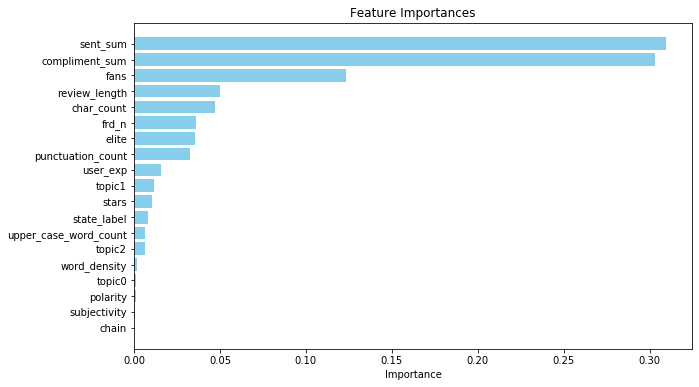

In [ ]:
features = [item[0] for item in sorted_features_importances_cv]
importances = [item[1] for item in sorted_features_importances_cv]
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

Computing time taken for training, train RMSE and R squared

In [ ]:
rf2 = RandomForestRegressor(labelCol="PopularityScore", featuresCol="features", numTrees=200)
pipeline_rf2 = Pipeline(stages=[assembler, rf2])

# fitting the Random Forest model
start_time = time.time()
rf_model = pipeline_rf2.fit(train_data)
train_time = time.time() - start_time
print("Training Time: %.2f seconds" % train_time)

Training Time: 92.90 seconds


In [ ]:
predictions_rf2 = rf_model.transform(train_data)
evaluator_rf2 = RegressionEvaluator(labelCol='PopularityScore', predictionCol='prediction', metricName='rmse')
rmse_rf2 = evaluator_rf2.evaluate(predictions_rf2)
r2_rf2 = evaluator_rf2.evaluate(predictions_rf2, {evaluator_rf2.metricName: "r2"})

print("Root Mean Squared Error (RMSE): %.4f" % rmse_rf2)
print("R-squared: %.4f" % r2_rf2)

Root Mean Squared Error (RMSE): 0.0596
R-squared: 0.3986


### Gradient Boosted Trees

In [80]:
from pyspark.ml.regression import GBTRegressor

In [95]:
gbt = GBTRegressor(featuresCol='features', labelCol='PopularityScore', maxIter=10)
pipeline3 = Pipeline(stages=[assembler, gbt])
evaluator3 = RegressionEvaluator(labelCol='PopularityScore', predictionCol='prediction', metricName='rmse')

#### Cross validation and hyperparameter tuning

In [96]:
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 30, 40]) \
    .build()

crossval = CrossValidator(estimator=pipeline3,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator3,
                          numFolds=3)

In [ ]:
cv_model = crossval.fit(train_data)

In [ ]:
best_model = cv_model.bestModel

predictions_cv = best_model.transform(test_data)

num_trees = best_model.stages[-1].getNumTrees
print("Number of Trees:", num_trees)

Number of Trees: 30


In [104]:
rmse_cv2 = evaluator3.evaluate(predictions_cv)
r2_cv2 = evaluator3.evaluate(predictions_cv, {evaluator3.metricName: "r2"})

print("Root Mean Squared Error (RMSE) with Cross-Validation: %.4f" % rmse_cv2)
print("R-squared with Cross-Validation: %.4f" % r2_cv2)

Root Mean Squared Error (RMSE) with Cross-Validation: 0.0590
R-squared with Cross-Validation: 0.3949


In [235]:
feature_importances_cv2 = best_model.stages[-1].featureImportances
features_importances_zip_cv2 = zip(feature_cols, feature_importances_cv2)
sorted_features_importances_cv2 = sorted(features_importances_zip_cv2, key=lambda x: x[1], reverse=True)

print("Feature Importances with Cross-Validation (sorted):")
for feature, importance in sorted_features_importances_cv2:
    print("\t%s: %.4f" % (feature, importance))

Feature Importances with Cross-Validation (sorted):
	sent_sum: 0.1457
	state_label: 0.1209
	compliment_sum: 0.0846
	user_exp: 0.0819
	fans: 0.0769
	word_density: 0.0720
	stars: 0.0631
	frd_n: 0.0536
	topic1: 0.0511
	punctuation_count: 0.0449
	polarity: 0.0382
	topic0: 0.0368
	char_count: 0.0331
	upper_case_word_count: 0.0310
	subjectivity: 0.0278
	review_length: 0.0205
	topic2: 0.0156
	elite: 0.0020
	chain: 0.0000


Similar to the random forest model, we see that:
- votes sent by the user
- compliments received, and 
- fans

are among the top five most important features in the model when predicting the popularity score of a review.

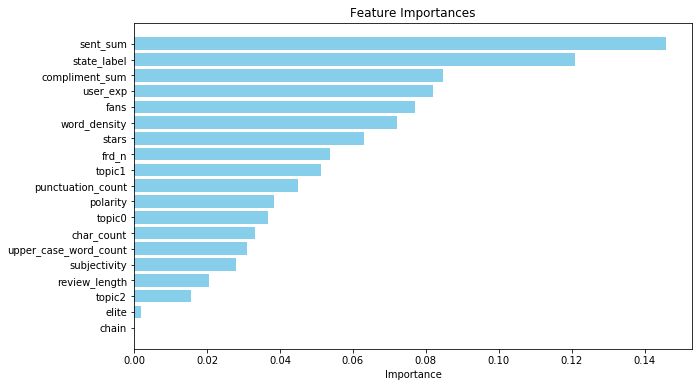

In [237]:
features = [item[0] for item in sorted_features_importances_cv2]
importances = [item[1] for item in sorted_features_importances_cv2]
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

Getting RMSE and R-squared for train data

In [ ]:
gbt2 = GBTRegressor(featuresCol='features', labelCol='PopularityScore', maxIter=30)
pipeline3 = Pipeline(stages=[assembler, gbt2])

#fitting the gradient boosting model
start_time = time.time()
gbt_model = pipeline3.fit(train_data)
train_time = time.time() - start_time
print("Training Time: %.2f seconds" % train_time)

Training Time: 665.36 seconds


In [ ]:
# evaluate the model
predictions_gbt2 = gbt_model.transform(train_data)
evaluator_gbt2 = RegressionEvaluator(labelCol='PopularityScore', predictionCol='prediction', metricName='rmse')
rmse_gbt2 = evaluator_gbt2.evaluate(predictions_gbt2)
r2_gbt2 = evaluator_gbt2.evaluate(predictions_gbt2, {evaluator_gbt2.metricName: "r2"})

print("Root Mean Squared Error (RMSE): %.4f" % rmse_gbt2)
print("R-squared: %.4f" % r2_gbt2)

Root Mean Squared Error (RMSE): 0.0557
R-squared: 0.4672


## Predicting for one business using Gradient Boosting

We use gradient boosting instead of random forest because it has lower RMSE and higher R-squared.

Preprocessing

In [84]:
# merging the dataframe
mydf = df_rev_subset.join(df_bus_subset, df_rev_subset.business_id == df_bus_subset.business_id, "left")
mydf = mydf.join(df_cus_subset, mydf.user_id == df_cus_subset.user_id, "left")\
                .drop(*["user_id"])\
                .cache()

In [85]:
mydf = mydf.drop(df_bus_subset.business_id)\
                .cache()

In [86]:
# checking for any na value
column_names = mydf.columns
# Calculating the number of NA values in each column
na_counts = [sql_f.sum(col(column).isNull().cast("integer")).alias(column) for column in column_names]
# Performing the aggregation to get the total NA counts per column
na_counts_df = mydf.agg(*na_counts)

#### Feature engineering

In [87]:
# getting the reviewer experience
mydf = mydf.withColumn("user_exp", expr("unix_timestamp(date) - unix_timestamp(yelping_since)"))
# returning elite status at the time of review
mydf = mydf.withColumn("year", year(col("date"))) # get the year
mydf = mydf.withColumn("elite", expr("array_contains(elite_year, year)")) # find the elite status
mydf = mydf.na.fill(False, subset=["elite"]) # fill in as False if elite_year is empty

In [88]:
# getting the reviewer experience
mydf = mydf.withColumn("user_exp", expr("unix_timestamp(date) - unix_timestamp(yelping_since)"))
# returning elite status at the time of review
mydf = mydf.withColumn("year", year(col("date"))) # get the year
mydf = mydf.withColumn("elite", expr("array_contains(elite_year, year)")) # find the elite status
mydf = mydf.na.fill(False, subset=["elite"]) # fill in as False if elite_year is empty
# inspecting the result
mydf.limit(5).toPandas()

,business_id,char_count,polarity,punctuation_count,review_length,subjectivity,upper_case_word_count,word_density,topic0,topic1,...,chain,compliment_sum,sent_sum,elite_year,frd_n,fans,yelping_since,user_exp,year,elite
0,GXaIBN_ALMoF7qYDsw416A,2777,0.2461,280,601,0.5209,33,4.612957,0.894438,0.002131,...,false,20711,62879,"[2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...",578,293,2012-04-05 01:01:05,172996611,2017,True
1,4MXnrz1I99c13tsv4aDkFA,263,0.0348,8,56,0.6029,1,4.614035,0.019398,0.962991,...,false,0,2,[None],0,0,2010-08-07 05:04:11,146618731,2015,False
2,HTgKfmmlzgE43trhntv8-w,546,0.5182,17,113,0.5844,2,4.789474,0.598814,0.391546,...,false,6,138,[None],11,0,2015-05-26 01:52:03,60366747,2017,False
3,6LYmMCltMzSMK-gMjqWTCw,609,0.3660,27,119,0.5085,1,5.075000,0.008090,0.984586,...,false,6,138,[None],11,0,2015-05-26 01:52:03,58282703,2017,False
4,L-VNs3YquPGKVsXl2Ze-Yg,931,0.2317,35,186,0.5997,1,4.978610,0.005037,0.990061,...,false,0,0,[None],0,0,2014-07-02 18:23:19,22195740,2015,False


In [89]:
# removing the irrelevant columns
cols_to_drop = ["date","elite_year","yelping_since","year"]
mydf = mydf.drop(*cols_to_drop)\
                .cache()

In [90]:
mydf.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- topic0: double (nullable = true)
 |-- topic1: double (nullable = true)
 |-- topic2: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- PopularityScore: double (nullable = true)
 |-- state: string (nullable = true)
 |-- chain: string (nullable = true)
 |-- compliment_sum: long (nullable = true)
 |-- sent_sum: long (nullable = true)
 |-- frd_n: integer (nullable = true)
 |-- fans: long (nullable = true)
 |-- user_exp: long (nullable = true)
 |-- elite: boolean (nullable = false)



#### Type casting

In [91]:
mydf = mydf.withColumn("chain", col("chain").cast(BooleanType())).cache()

In [92]:
mydf.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- topic0: double (nullable = true)
 |-- topic1: double (nullable = true)
 |-- topic2: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- PopularityScore: double (nullable = true)
 |-- state: string (nullable = true)
 |-- chain: boolean (nullable = true)
 |-- compliment_sum: long (nullable = true)
 |-- sent_sum: long (nullable = true)
 |-- frd_n: integer (nullable = true)
 |-- fans: long (nullable = true)
 |-- user_exp: long (nullable = true)
 |-- elite: boolean (nullable = false)



In [93]:
from pyspark.ml.feature import StringIndexer
string_indexer = StringIndexer(inputCol="state", outputCol="state_label")
string_indexer_model = string_indexer.fit(mydf)

In [94]:
mydf = string_indexer_model.transform(mydf)
mydf = mydf.drop("state")

In [95]:
mydf = mydf.select(
    *[col(column) for column in mydf.columns if column != 'PopularityScore'],
    col('PopularityScore')
)
mydf.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- topic0: double (nullable = true)
 |-- topic1: double (nullable = true)
 |-- topic2: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- chain: boolean (nullable = true)
 |-- compliment_sum: long (nullable = true)
 |-- sent_sum: long (nullable = true)
 |-- frd_n: integer (nullable = true)
 |-- fans: long (nullable = true)
 |-- user_exp: long (nullable = true)
 |-- elite: boolean (nullable = false)
 |-- state_label: double (nullable = false)
 |-- PopularityScore: double (nullable = true)



#### Predictions

Three reviews of the same business.
- Checking the three reviews of the most common business id
- Obtaining their predicted PopularityScore

In [96]:
from pyspark.sql import functions as F

most_common_business_id = mydf.groupBy("business_id").count().orderBy(F.desc("count")).first()["business_id"]

filtered_df = mydf.filter(mydf.business_id == most_common_business_id)

filtered_df = filtered_df.filter(filtered_df.PopularityScore != 0)
three_reviews_df = filtered_df.limit(3)

In [98]:
predictions_three = gbt_model.transform(three_reviews_df)
predictions_three.select("business_id", "text", "PopularityScore", "prediction").toPandas()

,business_id,text,PopularityScore,prediction
0,_ab50qdWOk0DdB6XOrBitw,"We landed at MSY on a super rainy, cold Friday...",0.055556,0.061174
1,_ab50qdWOk0DdB6XOrBitw,Bit of a disappointment. We came here expecti...,0.030303,0.032733
2,_ab50qdWOk0DdB6XOrBitw,"As my ever so frank brother in law put it, thi...",0.060606,0.051929


# Scaling to a larger subset - 10%

In [30]:
# subset 10% of the review data
df_rev_02 = df_rev.sample(withReplacement = False, fraction = 0.1,seed = 42).cache()

In [31]:
# Preprocessing the review data similarly as before
df_rev_pro2 = df_rev_02.rdd.map(lambda line: (line["review_id"], get_tokens(line["text"])))
df_rev_pro2 = spark.createDataFrame(df_rev_pro2, ["review_id","content"]).cache()

Since from our Random Forest and Gradient Boosted Trees models we noticed that the LDA topics are not key contributors to the model's predictions - therefore, since this data subset is very large, we decide to forgo the LDA topics as features.

<a id = "#rev-data_lin"></a>
##### Linguistic Features

We now obtain the linguistic features.

In [32]:
# define the processing pipeline
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    
    senti = sia()
    tt = TweetTokenizer()

    pos_family = {
        'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
        'pron': ['PRP', 'PRP$', 'WP', 'WP$'],
        'verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
        'adj': ['JJ', 'JJR', 'JJS'],
        'adv': ['RB', 'RBR', 'RBS', 'WRB']
    }

    def polarity(x):
        ss = TextBlob(str(x))
        return round(ss.sentiment.polarity, 4)

    def subjectivity(x):
        ss = TextBlob(str(x))
        return round(ss.sentiment.subjectivity, 4)

    def getfeatures(review_id,review):
        pol = polarity(review)
        subj = subjectivity(review)

        tokens = tt.tokenize(review)
        review_length = len(tokens)

        char_count = len(review)
        worddensity = char_count / (review_length + 1)
        punctuation_count = len("".join(_ for _ in review if _ in string.punctuation))
        upper_case_word_count = len([w for w in review.split() if w.isupper()])

        return {
            "review_id" : review_id,
            'polarity': pol,
            'subjectivity': subj,
            'review_length': review_length,
            'char_count': char_count,
            'word_density': worddensity,
            'punctuation_count': punctuation_count,
            'upper_case_word_count': upper_case_word_count}

In [33]:
# testing the pipeline
df_rev_pro_lin2 = df_rev_02.rdd.map(lambda row: getfeatures(row["review_id"],row["text"])).toDF()
# inspect the result
df_rev_pro_lin2.limit(2).toPandas()

/usr/lib/spark/python/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


,char_count,polarity,punctuation_count,review_id,review_length,subjectivity,upper_case_word_count,word_density
0,804,0.2897,22,6AxgBCNX_PNTOxmbRSwcKQ,168,0.4394,3,4.757396
1,1009,0.2985,25,rGQRf8UafX7OTlMNN19I8A,198,0.5649,5,5.070352


##### Merging the dataframes
We will merge the above two tables:
* Response Variable
* `df_rev_pro_lin` for the Linguistic Features

In [34]:
df_rev_pro2.columns

['review_id', 'content']

In [35]:
df_rev_pro_lin2.columns

['char_count',
 'polarity',
 'punctuation_count',
 'review_id',
 'review_length',
 'subjectivity',
 'upper_case_word_count',
 'word_density']

In [36]:
df_rev_subset2 = df_rev_pro_lin2.join(df_rev_pro2, 
                            df_rev_pro2.review_id == df_rev_pro_lin2.review_id,
                            "left")\
                            .drop(df_rev_pro_lin2["review_id"])

In [37]:
df_rev_subset2 = df_rev_subset2.join(df_rev, df_rev.review_id == df_rev_subset2.review_id, "left").drop(df_rev_subset2.review_id)

In [38]:
df_rev_subset2.columns

['char_count',
 'polarity',
 'punctuation_count',
 'review_length',
 'subjectivity',
 'upper_case_word_count',
 'word_density',
 'content',
 'business_id',
 'cool',
 'date',
 'funny',
 'review_id',
 'stars',
 'text',
 'useful',
 'user_id',
 'target_cool',
 'target_funny',
 'target_useful',
 'PopularityScore']

In [39]:
df_rev_subset2.printSchema()

root
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- content: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- business_id: string (nullable = true)
 |-- cool: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- funny: double (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: double (nullable = true)
 |-- user_id: string (nullable = true)
 |-- target_cool: double (nullable = true)
 |-- target_funny: double (nullable = true)
 |-- target_useful: double (nullable = true)
 |-- PopularityScore: double (nullable = true)



##### Subset the Review Data

In [40]:
# define the columns needed
sel_cols = ['business_id', 'user_id', 'char_count','polarity','punctuation_count', 'review_length', 'subjectivity', 'upper_case_word_count', 
            'word_density', 'date', 'stars', 'text', 'PopularityScore']
df_rev_subset2 = df_rev_subset2.select(sel_cols).cache()

In [41]:
df_rev_subset2.columns

['business_id',
 'user_id',
 'char_count',
 'polarity',
 'punctuation_count',
 'review_length',
 'subjectivity',
 'upper_case_word_count',
 'word_density',
 'date',
 'stars',
 'text',
 'PopularityScore']

<a if = "user-data"></a>
### User dataset

In [42]:
# load the data
path = f"hdfs://{cluster_name}-m:{cluster_port}/{files[4]}"
df_cus = spark.read.json(path)
df_cus.limit(5).toPandas()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,3.91,467,56,467,250,18,65,232,180,844,...,5994,2007,267,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",1259,Walker,585,7217,qVc8ODYU5SZjKXVBgXdI7w,2007-01-25 16:47:26
1,3.74,3131,157,3131,1145,251,264,1847,1946,7054,...,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",3138,"ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",13066,Daniel,4333,43091,j14WgRoU_-2ZE1aw1dXrJg,2009-01-25 04:35:42
2,3.32,119,17,119,89,3,13,66,18,96,...,1003,"2009,2010,2011,2012,2013",52,"LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",1010,Steph,665,2086,2WnXYQFK0hXEoTxPtV2zvg,2008-07-25 10:41:00
3,4.27,26,6,26,24,2,4,12,9,16,...,299,"2009,2010,2011",28,"enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",330,Gwen,224,512,SZDeASXq7o05mMNLshsdIA,2005-11-29 04:38:33
4,3.54,0,0,0,1,0,1,1,0,1,...,7,,1,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",15,Karen,79,29,hA5lMy-EnncsH4JoR-hFGQ,2007-01-05 19:40:59


In [43]:
print(f"The number of users in the table: {df_cus.count()}")

The number of users in the table: 1987897


In [44]:
# apply type casting on the date type
df_cus = df_cus.withColumn("yelping_since", col("yelping_since").cast(TimestampType())).cache()
df_cus.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: timestamp (nullable = true)



#### Pre-Processing: Reviewer (customer)
In the following section, we will pre-process the customer data with the procedures:
* Aggregate the compliment received
* Aggregate compliment sent
* Parse the elite column as a list of int
* Get aggerate of number friends

In [45]:
# first check for any na value
column_names = df_cus.columns
# Calculate the number of NA values in each column
na_counts = [sql_f.sum(col(column).isNull().cast("integer")).alias(column) for column in column_names]
# Perform the aggregation to get the total NA counts per column
na_counts_df = df_cus.agg(*na_counts)
# Show the DataFrame with NA counts
na_counts_df.show()

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+----+------------+------+-------+-------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|friends|funny|name|review_count|useful|user_id|yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+----+------------+------+-------+-------------+
|            0|              0|              0|               0|             0|              0|              0|              0|                0|               0|       

In [46]:
## get the compliment aggregate
# get the compliment column names
compliment_cols = [column for column in df_cus.columns if column.find("compliment") >=0]
# remove cool, funny, and useful
for column in ["compliment_cool","compliment_funny"]:
    compliment_cols.remove(column)
# define the sql expression to sum the column and return new column
sum_expr = sum(col(col_name) for col_name in compliment_cols)
df_cus = df_cus.withColumn("compliment_sum",sum_expr)

In [47]:
## get the compliment sent
sent_cols = ["funny","useful","cool"]
# define the sql expression to sum the column and return new column
sum_expr = sum(col(col_name) for col_name in sent_cols)
df_cus = df_cus.withColumn("sent_sum",sum_expr)

In [48]:
## get number of friends
# Define a UDF to find the occurrences of comma as the delimiter
def count_occurrences(text, substring = ","):
    return len(list(re.finditer(substring, text)))
# Register the UDF
count_occurrences_udf = udf(count_occurrences, IntegerType())
# apply the function of the customer df
df_cus = df_cus.withColumn("frd_n", count_occurrences_udf(col("friends")))

In [49]:
## parse the elite column as array of int
def string_to_array(string):
    try:
        return [int(x) for x in string.split(",")]
    except ValueError:
        return [None]
# Register the UDF
string_to_array_udf = spark.udf.register("string_to_array", string_to_array, ArrayType(IntegerType(),True))
# Add a new column with the array representation of the string of integers
df_cus = df_cus.withColumn("elite_year", string_to_array_udf(col("elite")))

In [50]:
# subset for the relevant columns only
# define the columns
sel_cols = ["user_id","compliment_sum","sent_sum","elite_year","frd_n",
           "fans","yelping_since"]
df_cus_subset2 = df_cus.select(sel_cols).cache()
df_cus_subset2.limit(2).toPandas()

,user_id,compliment_sum,sent_sum,elite_year,frd_n,fans,yelping_since
0,qVc8ODYU5SZjKXVBgXdI7w,1939,14470,[2007],14994,267,2007-01-25 16:47:26
1,j14WgRoU_-2ZE1aw1dXrJg,14369,83438,"[2009, 2010, 2011, 2012, 2013, 2014, 2015, 201...",4645,3138,2009-01-25 04:35:42


<a id = "full-df"></a>
### Merging the Data Frame and Further Processing
    

In [51]:
# merging the dataframe
full_df2 = df_rev_subset2.join(df_bus_subset, df_rev_subset2.business_id == df_bus_subset.business_id, "left")
full_df2 = full_df2.join(df_cus_subset2, full_df2.user_id == df_cus_subset2.user_id, "left")\
                .drop(*["business_id","user_id"])\
                .cache()

In [52]:
# check for any na value
column_names = full_df2.columns
# Calculate the number of NA values in each column
na_counts2 = [sql_f.sum(col(column).isNull().cast("integer")).alias(column) for column in column_names]
# Perform the aggregation to get the total NA counts per column
na_counts_df2 = full_df2.agg(*na_counts2)

Although there are some null values, these are just a small fraction that seems to arise due to the lack of user data in the table. We will simply remove them from our analysis.

<a id = "#full-df-engineering"></a>
#### Feature Engineering

In [53]:
# get the reviewer experience
full_df2 = full_df2.withColumn("user_exp", expr("unix_timestamp(date) - unix_timestamp(yelping_since)"))
# return elite status at the time of review
full_df2 = full_df2.withColumn("year", year(col("date"))) # get the year
full_df2 = full_df2.withColumn("elite", expr("array_contains(elite_year, year)")) # find the elite status
full_df2 = full_df2.na.fill(False, subset=["elite"]) # fill in as False if elite_year is empty

In [54]:
# remove the irrelevant columns
cols_to_drop = ["date","elite_year","yelping_since","year"]
full_df2 = full_df2.drop(*cols_to_drop)\
                .cache()

In [55]:
full_df2.printSchema()

root
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- PopularityScore: double (nullable = true)
 |-- state: string (nullable = true)
 |-- chain: string (nullable = true)
 |-- compliment_sum: long (nullable = true)
 |-- sent_sum: long (nullable = true)
 |-- frd_n: integer (nullable = true)
 |-- fans: long (nullable = true)
 |-- user_exp: long (nullable = true)
 |-- elite: boolean (nullable = false)



To summarise, the table that will be use to fit the data model:

| Variable          | Data Type   |  Description |
| ----              | ----        | ----         |
| state             | VarChar(2)  | The state in which the business the review referred to is located in.           |
| chain             | Boolean     | Whether the business the review referred to is a chain location.            |
| compliment_sum    | Integer     | The total number of compliment the reviewer of the review received.            |
| sent_sum          | Integer     | The total number of vote (useful, funny, cool) sent by the reviewer of the review.|
| frd_n             | Integer     | The total number of friends the reviewer of the review has.|
| fans              | Integer     | The total number of fans the reviewer of the review has.|
| user_exp          | Float       | The time (in seconds) the reviewer has been on Yelp at the time of leaving the review. |
| elite             | Boolean     | The elite status of the reviewer of the review at the year of leaving the review. |
| char_count        | Long        | The number of characters in the review i.e. length of the review. |
| polarity          | Double      | The sentiment polarity score of the review, ranging from -1 to 1 |
| punctuation_count | Long        | The count of punctuations in the review |
| review_length     | Long        | The number of tokens in the review |
| subjectivity      | Double      | How subjective a review is, with 0 indicating factual text and 1 indicating opinionated text |
| upper_case_word_count| Long     | The presence of uppercase words in the review text
| word_density      | Double      | The density of characters relative to words |
| stars             | Double      | The star rating provided |


#### Type casting

In [56]:
full_df2 = full_df2.withColumn("chain", col("chain").cast(BooleanType())).cache()

In [57]:
full_df2.printSchema()

root
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- PopularityScore: double (nullable = true)
 |-- state: string (nullable = true)
 |-- chain: boolean (nullable = true)
 |-- compliment_sum: long (nullable = true)
 |-- sent_sum: long (nullable = true)
 |-- frd_n: integer (nullable = true)
 |-- fans: long (nullable = true)
 |-- user_exp: long (nullable = true)
 |-- elite: boolean (nullable = false)



In [ ]:
# from pyspark.ml.feature import StringIndexer
# string_indexer = StringIndexer(inputCol="state", outputCol="state_label")
# string_indexer_model = string_indexer.fit(full_df2)

We do not run the above code due to its prolonged execution time hence we will not consider "state" as a feature. 

In [58]:
full_df2 = full_df2.drop("state")

In [59]:
full_df2 = full_df2.select(
    *[col(column) for column in full_df2.columns if column != 'PopularityScore'],
    col('PopularityScore')
)
full_df2.printSchema()

root
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- chain: boolean (nullable = true)
 |-- compliment_sum: long (nullable = true)
 |-- sent_sum: long (nullable = true)
 |-- frd_n: integer (nullable = true)
 |-- fans: long (nullable = true)
 |-- user_exp: long (nullable = true)
 |-- elite: boolean (nullable = false)
 |-- PopularityScore: double (nullable = true)



### Linear Regression

In [62]:
feature_cols = ['chain','compliment_sum','sent_sum','frd_n','fans','user_exp','elite','char_count','polarity', 
                'punctuation_count','review_length','subjectivity','upper_case_word_count','word_density','stars']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

train_data, test_data = full_df2.randomSplit([0.8, 0.2])

In [63]:
lr_scaled1 = LinearRegression(featuresCol='features', labelCol='PopularityScore')
pipeline_scaled1 = Pipeline(stages=[assembler, lr_scaled1])

In [88]:
start_time = time.time()
p_model_scaled1 = pipeline_scaled1.fit(train_data)
train_time = time.time() - start_time
print("Training Time: %.2f seconds" % train_time)

Training Time: 21.23 seconds


Computing metrics on both train and test data

In [67]:
train_predictions = p_model_scaled1.transform(train_data)
train_predictions = train_predictions.select("prediction", "PopularityScore")
evaluator = RegressionEvaluator(labelCol="PopularityScore", predictionCol="prediction", metricName="rmse")
rmse_train = evaluator.evaluate(train_predictions)
print("RMSE on train data = %g" % rmse_train)

evaluator_r2 = RegressionEvaluator(labelCol="PopularityScore", predictionCol="prediction", metricName="r2")
r2_train = evaluator_r2.evaluate(train_predictions)
print("R-squared on train data = %g" % r2_train)

RMSE on train data = 0.0646955
R-squared on train data = 0.305951


In [68]:
test_predictions = p_model_scaled1.transform(test_data)
test_predictions = test_predictions.select("prediction", "PopularityScore")
rmse_test = evaluator.evaluate(test_predictions)
print("RMSE on test data = %g" % rmse_test)

r2_test = evaluator_r2.evaluate(test_predictions)
print("R-squared on test data = %g" % r2_test)

RMSE on test data = 0.0647173
R-squared on test data = 0.309319


### Random Forest

In [72]:
rf = RandomForestRegressor(labelCol="PopularityScore", featuresCol="features", numTrees=200)
pipeline2_scaled = Pipeline(stages=[assembler, rf])
evaluator2_scaled = RegressionEvaluator(labelCol='PopularityScore', predictionCol='prediction', metricName='rmse')

In [73]:
start_time = time.time()
rf_model = pipeline2_scaled.fit(train_data)
train_time = time.time() - start_time
print("Training Time: %.2f seconds" % train_time)

Training Time: 131.93 seconds


Computing metrics on train and test data

In [76]:
predictions_rf2_scaled = rf_model.transform(train_data)
evaluator_rf2_scaled = RegressionEvaluator(labelCol='PopularityScore', predictionCol='prediction', metricName='rmse')
rmse_rf2_scaled = evaluator_rf2_scaled.evaluate(predictions_rf2_scaled)
r2_rf2_scaled = evaluator_rf2_scaled.evaluate(predictions_rf2_scaled, {evaluator_rf2_scaled.metricName: "r2"})

print("Root Mean Squared Error (RMSE): %.4f" % rmse_rf2_scaled)
print("R-squared: %.4f" % r2_rf2_scaled)

Root Mean Squared Error (RMSE): 0.0607
R-squared: 0.3884


In [79]:
predictions_rf2_scaled_test = rf_model.transform(test_data)
rmse_rf2_scaled_test = evaluator_rf2_scaled.evaluate(predictions_rf2_scaled_test)
r2_rf2_scaled_test = evaluator_rf2_scaled.evaluate(predictions_rf2_scaled_test, {evaluator_rf2_scaled_test.metricName: "r2"})

print("Root Mean Squared Error (RMSE): %.4f" % rmse_rf2_scaled_test)
print("R-squared: %.4f" % r2_rf2_scaled_test)

Root Mean Squared Error (RMSE): 0.0611
R-squared: 0.3838


### Gradient Boosted Trees

In [81]:
gbt = GBTRegressor(featuresCol='features', labelCol='PopularityScore', maxIter=30)
pipeline = Pipeline(stages=[assembler, gbt])

In [ ]:
start_time = time.time()
gbt_model = pipeline.fit(train_data)
train_time = time.time() - start_time
print("Training Time: %.2f seconds" % train_time)

Training Time: 542.23 seconds


Computing metric on both train and test data

In [86]:
predictions3_scaled_train = gbt_model.transform(train_data)

evaluator3_scaled = RegressionEvaluator(labelCol="PopularityScore", predictionCol="prediction", metricName="rmse")
rmse_3_scaled_train = evaluator3_scaled.evaluate(predictions3_scaled_train)
print("Root Mean Squared Error (RMSE): %.4f" % rmse_3_scaled_train)

evaluator_r2_3_scaled = RegressionEvaluator(labelCol="PopularityScore", predictionCol="prediction", metricName="r2")
r2_3_scaled_train = evaluator_r2_3_scaled.evaluate(predictions3_scaled_train)
print("R-squared: %.4f" % r2_3_scaled_train)

Root Mean Squared Error (RMSE): 0.0591
R-squared: 0.4217


In [83]:
predictions3_scaled_test = gbt_model.transform(test_data)

rmse_3_scaled_test = evaluator3_scaled.evaluate(predictions3_scaled_test)
print("Root Mean Squared Error (RMSE): %.4f" % rmse_3_scaled_test)

r2_3_scaled_test = evaluator_r2_3_scaled.evaluate(predictions3_scaled_test)
print("R-squared: %.4f" % r2_3_scaled_test)

Root Mean Squared Error (RMSE): 0.0598
R-squared: 0.4099


# Scaling to a larger subset - 30%

In [32]:
# subset 30% of the review data
df_rev_03 = df_rev.sample(withReplacement = False, fraction = 0.3,seed = 42).cache()

In [34]:
# Preprocessing the review data similarly as before
df_rev_pro3 = df_rev_03.rdd.map(lambda line: (line["review_id"], get_tokens(line["text"])))
df_rev_pro3 = spark.createDataFrame(df_rev_pro3, ["review_id","content"]).cache()

Since from our Random Forest and Gradient Boosted Trees models we noticed that the LDA topics are not key contributors to the model's predictions - therefore, since this data subset is very large, we decide to forgo the LDA topics as features.

<a id = "#rev-data_lin"></a>
##### Linguistic Features

In [35]:
# define the processing pipeline
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    
    senti = sia()
    tt = TweetTokenizer()

    pos_family = {
        'noun': ['NN', 'NNS', 'NNP', 'NNPS'],
        'pron': ['PRP', 'PRP$', 'WP', 'WP$'],
        'verb': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
        'adj': ['JJ', 'JJR', 'JJS'],
        'adv': ['RB', 'RBR', 'RBS', 'WRB']
    }

    def polarity(x):
        ss = TextBlob(str(x))
        return round(ss.sentiment.polarity, 4)

    def subjectivity(x):
        ss = TextBlob(str(x))
        return round(ss.sentiment.subjectivity, 4)


    def getfeatures(review_id,review):
        pol = polarity(review)
        subj = subjectivity(review)
        tokens = tt.tokenize(review)
        review_length = len(tokens)
        char_count = len(review)
        worddensity = char_count / (review_length + 1)
        punctuation_count = len("".join(_ for _ in review if _ in string.punctuation))
        upper_case_word_count = len([w for w in review.split() if w.isupper()])

        return {
            "review_id" : review_id,
            'polarity': pol,
            'subjectivity': subj,
            'review_length': review_length,
            'char_count': char_count,
            'word_density': worddensity,
            'punctuation_count': punctuation_count,
            'upper_case_word_count': upper_case_word_count}

In [36]:
# testing the pipeline
df_rev_pro_lin3 = df_rev_03.rdd.map(lambda row: getfeatures(row["review_id"],row["text"])).toDF()
# inspect the result
df_rev_pro_lin3.limit(2).toPandas()

/usr/lib/spark/python/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


,char_count,polarity,punctuation_count,review_id,review_length,subjectivity,upper_case_word_count,word_density
0,804,0.2897,22,6AxgBCNX_PNTOxmbRSwcKQ,168,0.4394,3,4.757396
1,192,0.5056,7,_ZeMknuYdlQcUqng_Im3yg,34,0.7889,1,5.485714


##### Merging the dataframes
We will merge the above two tables.

In [37]:
df_rev_pro3.columns

['review_id', 'content']

In [38]:
df_rev_pro_lin3.columns

['char_count',
 'polarity',
 'punctuation_count',
 'review_id',
 'review_length',
 'subjectivity',
 'upper_case_word_count',
 'word_density']

In [39]:
df_rev_subset3 = df_rev_pro_lin3.join(df_rev_pro3, 
                            df_rev_pro3.review_id == df_rev_pro_lin3.review_id,
                            "left")\
                            .drop(df_rev_pro_lin3["review_id"])

In [40]:
df_rev_subset3 = df_rev_subset3.join(df_rev, df_rev.review_id == df_rev_subset3.review_id, "left").drop(df_rev_subset3.review_id)

In [41]:
df_rev_subset3.columns

['char_count',
 'polarity',
 'punctuation_count',
 'review_length',
 'subjectivity',
 'upper_case_word_count',
 'word_density',
 'content',
 'business_id',
 'cool',
 'date',
 'funny',
 'review_id',
 'stars',
 'text',
 'useful',
 'user_id',
 'target_cool',
 'target_funny',
 'target_useful',
 'PopularityScore']

In [42]:
df_rev_subset3.printSchema()

root
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- content: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- business_id: string (nullable = true)
 |-- cool: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- funny: double (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: double (nullable = true)
 |-- user_id: string (nullable = true)
 |-- target_cool: double (nullable = true)
 |-- target_funny: double (nullable = true)
 |-- target_useful: double (nullable = true)
 |-- PopularityScore: double (nullable = true)



##### Subset the Review Data

In [43]:
# define the columns needed
sel_cols = ['business_id', 'user_id', 'char_count','polarity','punctuation_count', 'review_length', 'subjectivity', 'upper_case_word_count', 
            'word_density', 'date', 'stars', 'text', 'PopularityScore']
df_rev_subset3 = df_rev_subset3.select(sel_cols).cache()

In [44]:
df_rev_subset3.columns

['business_id',
 'user_id',
 'char_count',
 'polarity',
 'punctuation_count',
 'review_length',
 'subjectivity',
 'upper_case_word_count',
 'word_density',
 'date',
 'stars',
 'text',
 'PopularityScore']

<a if = "user-data"></a>
### User dataset

In [45]:
# load the data
path = f"hdfs://{cluster_name}-m:{cluster_port}/{files[4]}"
df_cus = spark.read.json(path)
df_cus.limit(5).toPandas()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,3.91,467,56,467,250,18,65,232,180,844,...,5994,2007,267,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",1259,Walker,585,7217,qVc8ODYU5SZjKXVBgXdI7w,2007-01-25 16:47:26
1,3.74,3131,157,3131,1145,251,264,1847,1946,7054,...,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",3138,"ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",13066,Daniel,4333,43091,j14WgRoU_-2ZE1aw1dXrJg,2009-01-25 04:35:42
2,3.32,119,17,119,89,3,13,66,18,96,...,1003,"2009,2010,2011,2012,2013",52,"LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",1010,Steph,665,2086,2WnXYQFK0hXEoTxPtV2zvg,2008-07-25 10:41:00
3,4.27,26,6,26,24,2,4,12,9,16,...,299,"2009,2010,2011",28,"enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",330,Gwen,224,512,SZDeASXq7o05mMNLshsdIA,2005-11-29 04:38:33
4,3.54,0,0,0,1,0,1,1,0,1,...,7,,1,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",15,Karen,79,29,hA5lMy-EnncsH4JoR-hFGQ,2007-01-05 19:40:59


In [53]:
print(f"The number of users in the table: {df_cus.count()}")

The number of users in the table: 1987897


In [46]:
# apply type casting on the date type
df_cus = df_cus.withColumn("yelping_since", col("yelping_since").cast(TimestampType())).cache()
df_cus.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: timestamp (nullable = true)



#### Pre-Processing: Reviewer (customer)
In the following section, we will pre-process the customer data with the procedures:
* Aggregate the compliment received
* Aggregate compliment sent
* Parse the elite column as a list of int
* Get aggerate of number friends

In [47]:
# first check for any na value
column_names = df_cus.columns
# Calculate the number of NA values in each column
na_counts = [sql_f.sum(col(column).isNull().cast("integer")).alias(column) for column in column_names]
# Perform the aggregation to get the total NA counts per column
na_counts_df = df_cus.agg(*na_counts)
# Show the DataFrame with NA counts
na_counts_df.show()

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+----+------------+------+-------+-------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|friends|funny|name|review_count|useful|user_id|yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+----+------------+------+-------+-------------+
|            0|              0|              0|               0|             0|              0|              0|              0|                0|               0|       

In [48]:
## get the compliment aggregate
# get the compliment column names
compliment_cols = [column for column in df_cus.columns if column.find("compliment") >=0]
# remove cool, funny, and useful
for column in ["compliment_cool","compliment_funny"]:
    compliment_cols.remove(column)
# define the sql expression to sum the column and return new column
sum_expr = sum(col(col_name) for col_name in compliment_cols)
df_cus = df_cus.withColumn("compliment_sum",sum_expr)

In [49]:
## get the compliment sent
sent_cols = ["funny","useful","cool"]
# define the sql expression to sum the column and return new column
sum_expr = sum(col(col_name) for col_name in sent_cols)
df_cus = df_cus.withColumn("sent_sum",sum_expr)

In [50]:
## get number of friends
# Define a UDF to find the occurrences of comma as the delimiter
def count_occurrences(text, substring = ","):
    return len(list(re.finditer(substring, text)))
# Register the UDF
count_occurrences_udf = udf(count_occurrences, IntegerType())
# apply the function of the customer df
df_cus = df_cus.withColumn("frd_n", count_occurrences_udf(col("friends")))

In [51]:
## parse the elite column as array of int
def string_to_array(string):
    try:
        return [int(x) for x in string.split(",")]
    except ValueError:
        return [None]
# Register the UDF
string_to_array_udf = spark.udf.register("string_to_array", string_to_array, ArrayType(IntegerType(),True))
# Add a new column with the array representation of the string of integers
df_cus = df_cus.withColumn("elite_year", string_to_array_udf(col("elite")))

In [52]:
# subset for the relevant columns only
# define the columns
sel_cols = ["user_id","compliment_sum","sent_sum","elite_year","frd_n",
           "fans","yelping_since"]
df_cus_subset3 = df_cus.select(sel_cols).cache()
df_cus_subset3.limit(2).toPandas()

,user_id,compliment_sum,sent_sum,elite_year,frd_n,fans,yelping_since
0,qVc8ODYU5SZjKXVBgXdI7w,1939,14470,[2007],14994,267,2007-01-25 16:47:26
1,j14WgRoU_-2ZE1aw1dXrJg,14369,83438,"[2009, 2010, 2011, 2012, 2013, 2014, 2015, 201...",4645,3138,2009-01-25 04:35:42


<a id = "full-df"></a>
### Merging the Data Frame and Further Processing

In [53]:
# merging the dataframe
full_df3 = df_rev_subset3.join(df_bus_subset, df_rev_subset3.business_id == df_bus_subset.business_id, "left")
full_df3 = full_df3.join(df_cus_subset3, full_df3.user_id == df_cus_subset3.user_id, "left")\
                .drop(*["business_id","user_id"])\
                .cache()

<a id = "#full-df-engineering"></a>
#### Feature Engineering

In [54]:
# get the reviewer experience
full_df3 = full_df3.withColumn("user_exp", expr("unix_timestamp(date) - unix_timestamp(yelping_since)"))
# return elite status at the time of review
full_df3 = full_df3.withColumn("year", year(col("date"))) # get the year
full_df3 = full_df3.withColumn("elite", expr("array_contains(elite_year, year)")) # find the elite status
full_df3 = full_df3.na.fill(False, subset=["elite"]) # fill in as False if elite_year is empty

In [55]:
# remove the irrelevant columns
cols_to_drop = ["date","elite_year","yelping_since","year"]
full_df3 = full_df3.drop(*cols_to_drop)\
                .cache()

In [56]:
full_df3.printSchema()

root
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- PopularityScore: double (nullable = true)
 |-- state: string (nullable = true)
 |-- chain: string (nullable = true)
 |-- compliment_sum: long (nullable = true)
 |-- sent_sum: long (nullable = true)
 |-- frd_n: integer (nullable = true)
 |-- fans: long (nullable = true)
 |-- user_exp: long (nullable = true)
 |-- elite: boolean (nullable = false)



To summarise, the table that will be use to fit the data model:

| Variable          | Data Type   |  Description |
| ----              | ----        | ----         |
| state             | VarChar(2)  | The state in which the business the review referred to is located in.           |
| chain             | Boolean     | Whether the business the review referred to is a chain location.            |
| compliment_sum    | Integer     | The total number of compliment the reviewer of the review received.            |
| sent_sum          | Integer     | The total number of vote (useful, funny, cool) sent by the reviewer of the review.|
| frd_n             | Integer     | The total number of friends the reviewer of the review has.|
| fans              | Integer     | The total number of fans the reviewer of the review has.|
| user_exp          | Float       | The time (in seconds) the reviewer has been on Yelp at the time of leaving the review. |
| elite             | Boolean     | The elite status of the reviewer of the review at the year of leaving the review. |
| char_count        | Long        | The number of characters in the review i.e. length of the review. |
| polarity          | Double      | The sentiment polarity score of the review, ranging from -1 to 1 |
| punctuation_count | Long        | The count of punctuations in the review |
| review_length     | Long        | The number of tokens in the review |
| subjectivity      | Double      | How subjective a review is, with 0 indicating factual text and 1 indicating opinionated text |
| upper_case_word_count| Long     | The presence of uppercase words in the review text
| word_density      | Double      | The density of characters relative to words |
| stars             | Double      | The star rating provided |


#### Type casting

In [57]:
full_df3 = full_df3.withColumn("chain", col("chain").cast(BooleanType())).cache()

In [58]:
full_df3.printSchema()

root
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- PopularityScore: double (nullable = true)
 |-- state: string (nullable = true)
 |-- chain: boolean (nullable = true)
 |-- compliment_sum: long (nullable = true)
 |-- sent_sum: long (nullable = true)
 |-- frd_n: integer (nullable = true)
 |-- fans: long (nullable = true)
 |-- user_exp: long (nullable = true)
 |-- elite: boolean (nullable = false)



In [ ]:
# from pyspark.ml.feature import StringIndexer
# string_indexer = StringIndexer(inputCol="state", outputCol="state_label")
# string_indexer_model = string_indexer.fit(full_df3)

We do not run the above code due to its prolonged execution time. We will therefore not be considering state as a feature this time.

In [62]:
full_df3 = full_df3.drop("state")

In [63]:
full_df3 = full_df3.select(
    *[col(column) for column in full_df3.columns if column != 'PopularityScore'],
    col('PopularityScore')
)
full_df3.printSchema()

root
 |-- char_count: long (nullable = true)
 |-- polarity: double (nullable = true)
 |-- punctuation_count: long (nullable = true)
 |-- review_length: long (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- upper_case_word_count: long (nullable = true)
 |-- word_density: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- chain: boolean (nullable = true)
 |-- compliment_sum: long (nullable = true)
 |-- sent_sum: long (nullable = true)
 |-- frd_n: integer (nullable = true)
 |-- fans: long (nullable = true)
 |-- user_exp: long (nullable = true)
 |-- elite: boolean (nullable = false)
 |-- PopularityScore: double (nullable = true)



## Model Fitting

### Linear Regression

In [78]:
import time
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In [79]:
feature_cols = ['chain','compliment_sum','sent_sum','frd_n','fans','user_exp','elite','char_count','polarity', 
                'punctuation_count','review_length','subjectivity','upper_case_word_count','word_density','stars']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

train_data, test_data = full_df3.randomSplit([0.8, 0.2])

In [80]:
from pyspark.ml.regression import LinearRegressionModel

lr = LinearRegression(featuresCol='features', labelCol='PopularityScore')
pipeline = Pipeline(stages=[assembler, lr])

In [81]:
assembler.setHandleInvalid("skip")

VectorAssembler_2fe0da781f69

In [82]:
start_time = time.time()
p_model = pipeline.fit(train_data)
train_time = time.time() - start_time
print("Training Time: %.2f seconds" % train_time)

Training Time: 18.72 seconds


Computing metrics on both train and test data

In [84]:
from pyspark.ml.evaluation import RegressionEvaluator

train_predictions = p_model.transform(train_data)
train_predictions = train_predictions.select("prediction", "PopularityScore")
evaluator = RegressionEvaluator(labelCol="PopularityScore", predictionCol="prediction", metricName="rmse")
rmse_train = evaluator.evaluate(train_predictions)
print("RMSE on train data = %g" % rmse_train)

evaluator_r2 = RegressionEvaluator(labelCol="PopularityScore", predictionCol="prediction", metricName="r2")
r2_train = evaluator_r2.evaluate(train_predictions)
print("R-squared on train data = %g" % r2_train)

RMSE on train data = 0.0646534
R-squared on train data = 0.306403


In [85]:
test_predictions = p_model.transform(test_data)
test_predictions = test_predictions.select("prediction", "PopularityScore")

rmse_test = evaluator.evaluate(test_predictions)
print("RMSE on test data = %g" % rmse_test)

r2_test = evaluator_r2.evaluate(test_predictions)
print("R-squared on test data = %g" % r2_test)

RMSE on test data = 0.0645509
R-squared on test data = 0.304926


### Random Forest

In [86]:
from pyspark.ml.regression import RandomForestRegressor

We use 200 trees (as previously obtained during hyperparameter tuning).

In [ ]:
rf30 = RandomForestRegressor(labelCol="PopularityScore", featuresCol="features", numTrees=200)
pipeline_rf30 = Pipeline(stages=[assembler, rf30])


start_time = time.time()
rf30_model = pipeline_rf30.fit(train_data)
train_time = time.time() - start_time
print("Training Time: %.2f seconds" % train_time)

Training Time: 6246.64 seconds


Computing metrics on both the train and test data

In [ ]:
predictions_rf30 = rf30_model.transform(train_data)
evaluator_rf30 = RegressionEvaluator(labelCol='PopularityScore', predictionCol='prediction', metricName='rmse')
rmse_rf30 = evaluator_rf30.evaluate(predictions_rf30)
r2_rf30 = evaluator_rf30.evaluate(predictions_rf30, {evaluator_rf30.metricName: "r2"})

print("Root Mean Squared Error (RMSE): %.4f" % rmse_rf30)
print("R-squared: %.4f" % r2_rf30)

Root Mean Squared Error (RMSE): 0.0607
R-squared: 0.3878


In [ ]:
predictions_rf30 = rf30_model.transform(test_data)
rmse_rf30 = evaluator_rf30.evaluate(predictions_rf30)
r2_rf30 = evaluator_rf30.evaluate(predictions_rf30, {evaluator_rf30.metricName: "r2"})

print("Root Mean Squared Error (RMSE): %.4f" % rmse_rf30)
print("R-squared: %.4f" % r2_rf30)

Root Mean Squared Error (RMSE): 0.0607
R-squared: 0.3856


Since the Gradient Boosted Trees take prolonged execution time during training for this level of scaling of our dataset, we are unable to obtain results from them.

# Conclusion

Our analysis on Yelp data has provided valuable insights into the different factors that influence the popularity of reviews on the platform and can be used to predict the reach of a review. By examining various features of the review ranging from its linguistic characteristics to the attributes of the reviewer, we have identified key predictors of review popularity. 

Our work is significant in the direction to aid stakeholders better understand the user engagement on popular platforms like Yelp as well as for researchers seeking to understand user behavior on review platforms. Moving forward, further research in this area can contribute to a more comprehensive understanding of online user engagement and decision-making processes.